In [58]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [59]:
mnist_data = pd.read_csv("mnist_train.csv").values.tolist()
print("Read data, Number of images in the dataset: ", len(mnist_data))
# Convert mnist_data to a NumPy array
mnist_data = np.array(mnist_data)
num_samples = len(mnist_data)
num_train_samples = num_samples - 1000

X_train = mnist_data[:num_train_samples, 1:].astype(np.float32) / 255.0
Y_train = np.zeros((num_train_samples, 10), dtype=np.float32)
Y_train[np.arange(num_train_samples), mnist_data[:num_train_samples, 0].astype(int)] = 1.0

X_test = mnist_data[num_train_samples:, 1:].astype(np.float32) / 255.0
Y_test = np.zeros((1000, 10), dtype=np.float32)
Y_test[np.arange(1000), mnist_data[num_train_samples:, 0].astype(int)] = 1.0

X_train = torch.from_numpy(X_train)
Y_train = torch.from_numpy(Y_train)
X_test = torch.from_numpy(X_test)
Y_test = torch.from_numpy(Y_test)

Read data, Number of images in the dataset:  50558


In [91]:
class ReLU:
    @staticmethod
    def forward(x):
        return torch.max(torch.zeros_like(x), x)
    
    @staticmethod
    def backward(doutput, x):
        doutput = doutput.clone()
        doutput[x < 0] = 0
        return doutput

class FullyConnectedLayer:
    def __init__(self, input_size, output_size):
        self.weights = torch.randn((output_size, input_size)) * 0.01
        self.bias = torch.randn((1, output_size))
        self.cached_input = None
        self.dW = None
        self.dB = None
    
    def forward(self, x):
        self.cached_input = x
        return torch.matmul(x, self.weights.t()) + self.bias
    
    def backward(self, doutput):
        dinput = torch.matmul(doutput, self.weights)
        self.dW = torch.mm(doutput.t(), self.cached_input)
        self.dB = torch.sum(doutput, dim=0)
        return dinput

    def update_parameters(self, lr):
        self.weights -= lr * self.dW
        self.bias -= lr * self.dB

class NNetwork:
    def __init__(self, layer_sizes):
        self.layers = []
        for i in range(len(layer_sizes) - 1):
            self.layers.append(FullyConnectedLayer(layer_sizes[i], layer_sizes[i + 1]))
    
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = layer.forward(x)
            x = ReLU.forward(x)
            layer.cached_input = x
        x = self.layers[-1].forward(x)
        return x
    
    def backward(self, doutput):
        dinput = self.layers[-1].backward(doutput)
        
        dWeights = []
        dBias = []
        for i in range(len(self.layers) - 1, -1, -1):
            dWeights.insert(0, self.layers[i].dW)
            dBias.insert(0, self.layers[i].dB)
            if i > 0: dinput = 1
        
        return dinput, dWeights, dBias
    
    def update_parameters(self, lr):
        for layer in self.layers:
            layer.update_parameters(lr)

layer_sizes = [784, 100, 12, 10]
net = NNetwork(layer_sizes)

lr = 0.2
mini_batch_size = 80
iterations = 8000

listLoss = []
for i in range(iterations):
    # Get a random mini-batch
    random_indices = torch.randperm(X_train.shape[0])
    random_indices = random_indices[:mini_batch_size]
    X_train_mini_batch = X_train[random_indices]
    Y_train_mini_batch = Y_train[random_indices]

    net.forward(X_train_mini_batch)

    #log_probs = torch.log_softmax(net.layers[-1].cached_input, dim=1)
    #logloss = -torch.sum(log_probs * Y_train_mini_batch) / X_train_mini_batch.shape[0]

    net.backward(Y_train_mini_batch)
    net.update_parameters(lr)

    #listLoss.append(logloss)
    #if i % 100 == 0: print("Iteration: ", i, "Loss: ", logloss)

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [90]:
# Test on 1000 test images
correct = 0
for n in range(0, 1000):
    forwardFirstLayer = net.forward(X_test[n])
    if torch.argmax(forwardFirstLayer) == torch.argmax(Y_test[n]):
        correct += 1
print("Test Accuracy:", (correct / 10))

Test Accuracy: 9.7


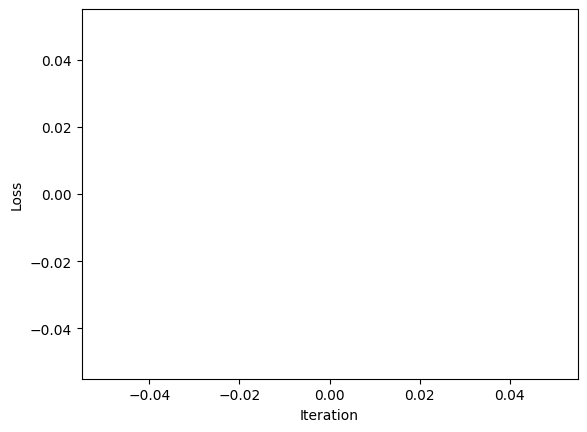

In [38]:
#plot the loss
plt.plot(listLoss)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()